# BinWaves example in Cantabria (Reconstruction)

**In this notebook**: 
<br><br>
Here waves are reconstructed in a selected grid.
<br><br>
Steps:
- Kp propagation coefficients and hindcast reconstruction is made at a grid.

In [1]:
import xarray as xr

# Load all the gridded kps and reproject

kp_coeffs = xr.open_dataset("outputs/kp_coeffs_gridded.nc").rename({"case": "case_num"})
kp_coeffs

<xarray.Dataset> Size: 33GB
Dimensions:   (utm_y: 71, utm_x: 120, case_num: 696, freq: 29, dir: 24)
Coordinates:
  * case_num  (case_num) int64 6kB 0 1 2 3 4 5 6 ... 689 690 691 692 693 694 695
  * dir       (dir) float64 192B 7.5 22.5 37.5 52.5 ... 307.5 322.5 337.5 352.5
  * freq      (freq) float32 116B 0.035 0.0385 0.04235 ... 0.4171 0.4589 0.5047
  * utm_x     (utm_x) float64 960B 4.2e+05 4.205e+05 ... 4.792e+05 4.797e+05
  * utm_y     (utm_y) float64 568B 4.802e+06 4.803e+06 ... 4.837e+06 4.838e+06
Data variables:
    kp        (utm_y, utm_x, case_num, freq, dir) float64 33GB ...

(np.float64(410000.0),
 np.float64(479197.7),
 np.float64(4802379.0),
 np.float64(4837093.5))

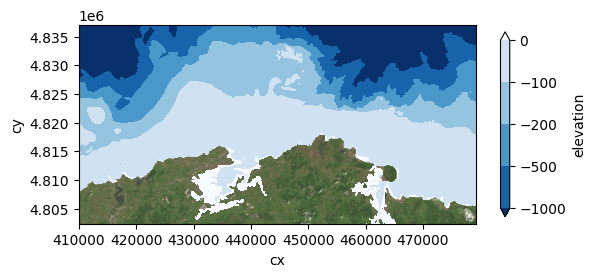

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mimg

fig, ax  = plt.subplots()

# Plot area of interest and bathymetry

bathy = xr.open_dataset("outputs/bathymetry_100m.nc").elevation.T
bathy.plot.contourf(
    ax=ax, 
    levels=[0, -100, -200, -500, -1000], 
    cmap="Blues_r", 
    cbar_kwargs={"shrink": 0.5}
)

ortophoto = mimg.imread("outputs/ortophoto_cantabria.png")
image_bounds = (
    410000.0, 
    479197.7,
    4802379.0, 
    4837093.5,
)
ax.imshow(
    ortophoto,
    extent=image_bounds,
)
ax.axis(image_bounds)

In [ ]:
# Select the kps of interest
# Try not to select more than 35 sites approx

utm_x_bounds = (425000, 455000, 15)
utm_y_bounds = (4805000, 4825000, 5)

selected_kps = kp_coeffs.sel(utm_x=slice(*utm_x_bounds), utm_y=slice(*utm_y_bounds))
selected_kps_site = selected_kps.stack(site=("utm_x", "utm_y"))
selected_kps_site

<xarray.Dataset> Size: 124MB
Dimensions:   (case_num: 696, freq: 29, dir: 24, site: 32)
Coordinates:
  * case_num  (case_num) int64 6kB 0 1 2 3 4 5 6 ... 689 690 691 692 693 694 695
  * dir       (dir) float64 192B 7.5 22.5 37.5 52.5 ... 307.5 322.5 337.5 352.5
  * freq      (freq) float32 116B 0.035 0.0385 0.04235 ... 0.4171 0.4589 0.5047
  * site      (site) object 256B MultiIndex
  * utm_x     (site) float64 256B 4.25e+05 4.25e+05 ... 4.476e+05 4.476e+05
  * utm_y     (site) float64 256B 4.805e+06 4.808e+06 ... 4.82e+06 4.823e+06
Data variables:
    kp        (case_num, freq, dir, site) float64 124MB 0.0 0.0 0.0 ... 0.0 0.0

In [4]:
import pandas as pd
from utils.operations import transform_ERA5_spectrum

model_parameters = pd.read_csv("outputs/swan_cases.csv").to_dict(orient="list")

# Load interest spectra

offshore_spectra, offshore_spectra_case = transform_ERA5_spectrum(
    era5_spectrum=xr.open_dataset("outputs/ERA5_offshore_spectra.nc"),
    subset_parameters=model_parameters,
    available_case_num=selected_kps_site.case_num.values,
)
offshore_spectra

<xarray.Dataset> Size: 98MB
Dimensions:    (dir: 24, freq: 29, time: 17520)
Coordinates:
    longitude  float32 4B ...
    latitude   float32 4B ...
  * dir        (dir) float64 192B 7.5 22.5 37.5 52.5 ... 307.5 322.5 337.5 352.5
  * freq       (freq) float32 116B 0.035 0.0385 0.04235 ... 0.4171 0.4589 0.5047
  * time       (time) datetime64[ns] 140kB 2009-01-01 ... 2010-12-31T23:00:00
Data variables:
    efth       (time, freq, dir) float64 98MB 0.0 0.0 0.0 ... 0.0 0.0 2.2e-05
    u10m       (time) float32 70kB ...
    v10m       (time) float32 70kB ...
    Wspeed     (time) float32 70kB ...
    Wdir       (time) float32 70kB ...
    Depth      (time) int64 140kB ...

In [5]:
from bluemath_tk.waves.binwaves import reconstruc_spectra

# Reconstruct spectra

time_to_reconstruct = "2010-02-20"

reconstructed_onshore_spectra = reconstruc_spectra(
    offshore_spectra=offshore_spectra_case.sel(time=time_to_reconstruct),
    kp_coeffs=selected_kps_site,
)
reconstructed_onshore_spectra

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.diskutils:Found stale lock file and directory '/tmp/dask-scratch-space/worker-whb5qo8g', purging
INFO:distributed.diskutils:Found stale lock file and directory '/tmp/dask-scratch-space/scheduler-oylex19j', purging
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:34177
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42389'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:45787'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:41777 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:41777
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:3

<xarray.Dataset> Size: 4MB
Dimensions:    (dir: 24, freq: 29, site: 32, time: 24)
Coordinates:
  * dir        (dir) float64 192B 7.5 22.5 37.5 52.5 ... 307.5 322.5 337.5 352.5
  * freq       (freq) float32 116B 0.035 0.0385 0.04235 ... 0.4171 0.4589 0.5047
  * site       (site) object 256B MultiIndex
  * utm_x      (site) float64 256B 4.25e+05 4.25e+05 ... 4.476e+05 4.476e+05
  * utm_y      (site) float64 256B 4.805e+06 4.808e+06 ... 4.82e+06 4.823e+06
    longitude  float32 4B 356.1
    latitude   float32 4B 43.82
  * time       (time) datetime64[ns] 192B 2010-02-20 ... 2010-02-20T23:00:00
Data variables:
    kp         (time, freq, dir, site) float64 4MB 0.0 0.0 ... 2.733e-05

(<Figure size 1500x600 with 2 Axes>, <Axes: xlabel='cx', ylabel='cy'>)

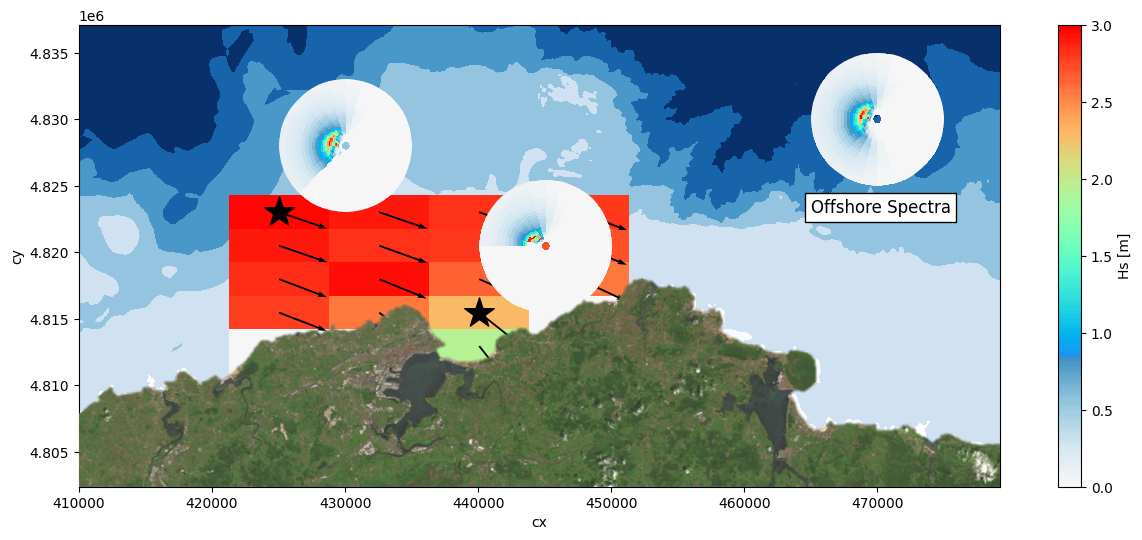

In [6]:
from utils.plotting import plot_spectrum_in_coastline

time_to_plot = "2010-02-20 12:00"

# Plot the spectrum along the coastline

plot_spectrum_in_coastline(
    bathy=bathy,
    reconstructed_onshore_spectra=reconstructed_onshore_spectra,
    reconstruction_kps=selected_kps,
    offshore_spectra=offshore_spectra,
    time_to_plot=time_to_plot,
    sites_for_spectrum=[7, 20],
    ortophoto=ortophoto,
)